## Imports

In [25]:
import pandas as pd
import numpy as np

In [26]:
dfr = pd.read_csv('../Data/2.electronics_cleaned.csv',header=0)

In [27]:
dfr.head()

,reviewerId,productId,ratings,timestamp
0,A2B4F6LP0ZLI8E,0594296420,3.0,1398556800
1,A1RKH6803HVOQL,0594296420,5.0,1365379200
2,A3ZNVCQCG57AY,0594296420,5.0,1359331200
3,A1HM74IXWXQ5D8,0594296420,5.0,1392854400
4,A2DUI0YVE1DZ48,0594296420,5.0,1388016000


## Model Selection

### Surprise Package

Surprise Package  :http://surpriselib.com/
        
References

Documentation :https://surprise.readthedocs.io/en/latest/
Installation: http://surpriselib.com/
Github : https://github.com/NicolasHug/Surprise

There are a lot of different packages available to build a recommender system. For this one, I'm using the Surprise package. Surprise has many different algorithms built in.Itprovides various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.

In this case, I need to load in a custom dataset to use with Surprise. According to the documentation, we need to make sure our data frame has three columns: the user ids, the item ids, and the ratings. Additionally, we'll need to specify the rating scale. In our case, users has used the ratings discretely from 1 to 5.

With the Surprise library, I use below algorithms

* <b>BaselineOnly:</b>Algorithm predicting the baseline estimate for a given user and item.
        
* <b>KNNBaseline:</b>A basic collaborative filtering algorithm taking into account a baseline rating.
    
* <b>NMF:</b>A collaborative filtering algorithm based on Non-negative Matrix Factorization. 
    
* <b>Co-clustering:</b>A collaborative filtering algorithm based on co-clustering.

* <b>SVD:</b>When baselines are not used, this is equivalent to Probabilistic Matrix Factorization, it is as popularized by Simon Funk during the Netflix Prize
    
I'm also split the data into training and testing data using the Surprise package


In [28]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import BaselineOnly
from surprise import SVD
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

To load a dataset from a pandas dataframe, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

In [29]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(dfr[['reviewerId', 'productId', 'ratings']], reader)

In [30]:
algoresults = []
algorithm = BaselineOnly()

# using baselineOnly Perform cross validation
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series(str('BaselineOnly()'), index=['Algorithm']))
algoresults.append(tmp)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [31]:
# using SVD Perform cross validation
algorithm = SVD()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series(str('SVD()'), index=['Algorithm']))
algoresults.append(tmp)

In [32]:
# using Coclustering Perform cross validation
algorithm = CoClustering()
results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
# Get results & append algorithm name
tmp = pd.DataFrame.from_dict(results).mean(axis=0)
tmp = tmp.append(pd.Series(str('CoClustering()'), index=['Algorithm']))
algoresults.append(tmp)

In [33]:
surprise_results = pd.DataFrame(algoresults).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
BaselineOnly(),1.291117,1.018094,5.764257,2.878079
SVD(),1.295390,1.018963,52.802452,3.046659
CoClustering(),1.445493,1.115695,83.513256,2.960003


BaselineOnly algorithm has given the best rmse, therefore, let me proceed further with BaselineOnly.

### Split and fine tune 

In [34]:
#ref :https://surprise.readthedocs.io/en/latest/prediction_algorithms.html
trainset, testset = train_test_split(data, test_size=0.25)
bsl_options = {'method': 'als','n_epochs': 10,'reg_u': 12,'reg_i': 10}
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.2877


1.287669254474015

In [35]:
predictions[:5]

[Prediction(uid='A37KC99QMAT10X', iid='B007WTAJTO', r_ui=1.0, est=4.399391505600358, details={'was_impossible': False}),
 Prediction(uid='A6LC0TZEMJI57', iid='B002N841RA', r_ui=5.0, est=4.332971007278731, details={'was_impossible': False}),
 Prediction(uid='A4PCS06KJKLPM', iid='B00006I5J7', r_ui=5.0, est=4.625860408371715, details={'was_impossible': False}),
 Prediction(uid='A1AV6UWE5EJTP4', iid='B0019EHU8G', r_ui=5.0, est=4.748726147916468, details={'was_impossible': False}),
 Prediction(uid='A3RARTEIEG0SE0', iid='B0002JY712', r_ui=3.0, est=4.654698573126473, details={'was_impossible': False})]

Let me use the train_test_split() to sample a trainset and a testset, and use the accuracy metric of rmse. Then use the fit() method to train the algorithm on the trainset, and the test() method which will return the predictions made from the testset

In [36]:
def get_itemsCounts_byReviewer(uid):
    """uid: the id of the user,returns:the number of items rated by the user """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
    
def get_reviwerCounts_forItem(iid):
    """ iid: the raw id of the item,returns:the number of users that have rated the item."""
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['itemsCounts_byReviewer'] = df.uid.apply(get_itemsCounts_byReviewer)
df['reviwerCounts_forItem'] = df.iid.apply(get_reviwerCounts_forItem)
df['err'] = abs(df.est - df.rui)

In [37]:
df = df.rename(columns={'uid': 'reviewerId'})
df = df.rename(columns={'iid': 'productId'})
df = df.rename(columns={'rui': 'ratings'})
df = df.rename(columns={'est': 'predicted Ratings'})
df=df.drop(['details'],axis = 1)

In [38]:
df.head()

,reviewerId,productId,ratings,predicted Ratings,itemsCounts_byReviewer,reviwerCounts_forItem,err
0,A37KC99QMAT10X,B007WTAJTO,1.0,4.399392,0,10683,3.399392
1,A6LC0TZEMJI57,B002N841RA,5.0,4.332971,0,111,0.667029
2,A4PCS06KJKLPM,B00006I5J7,5.0,4.625860,0,290,0.374140
3,A1AV6UWE5EJTP4,B0019EHU8G,5.0,4.748726,0,9265,0.251274
4,A3RARTEIEG0SE0,B0002JY712,3.0,4.654699,1,607,1.654699


In [39]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [58]:
best_predictions

,reviewerId,productId,ratings,predicted Ratings,itemsCounts_byReviewer,reviwerCounts_forItem,err
107286,AUQKQ2Q0N5N79,B005DB6NG6,3.0,2.999966,1,27,0.000034
277341,A1JFEP3BI48Q33,B0094Z6N9Y,3.0,3.000041,0,176,0.000041
242103,A2AKFOQKKC1M2G,B0094Z6N9Y,3.0,3.000041,0,176,0.000041
307506,A1WQ0YSLJ06KFT,B0094Z6N9Y,3.0,3.000041,0,176,0.000041
202183,AOAVQTWTYP8C0,B0094Z6N9Y,3.0,3.000041,0,176,0.000041
40597,A2TQCR6GN8XSP6,B0094Z6N9Y,3.0,3.000041,0,176,0.000041
302422,A1CKWE4BW40LLG,B0094Z6N9Y,3.0,3.000041,0,176,0.000041
175043,AC5GLGVJXDEFV,B000IF51UQ,4.0,4.000056,2,512,0.000056
9586,AMIWD0PA1H1YB,B000HGHMF8,4.0,4.000077,5,26,0.000077
66049,A2SZZB6Y5X9T8M,B0028E1E2Y,4.0,4.000124,1,41,0.000124


The above are the top 10 best Predictions. The product 'B000HGHMF8','B000IF51UQ' and 'B0028E1E2Y' are rated best with ratings 4.

In [41]:
worst_predictions

,reviewerId,productId,ratings,predicted Ratings,itemsCounts_byReviewer,reviwerCounts_forItem,err
119632,A195EZSQDW3E21,B004J3V90Y,1.0,4.870298,19,1221,3.870298
8116,A227IMN9BB71BO,B0019EHU8G,1.0,4.880704,2,9265,3.880704
299570,AGR1V15L6FLMA,B007WTAJTO,1.0,4.894745,16,10683,3.894745
293699,A2QIX73WKLLDRV,B004Z4FBE2,1.0,4.902412,3,1154,3.902412
167309,ARXYNHFIXEYO2,B00BEW8MVC,1.0,4.909606,3,172,3.909606
333029,A1D9V11QUHXENQ,B004LSNF04,1.0,4.926395,6,1448,3.926395
241191,AC8YM4BB5LVOM,B0045JCFLY,1.0,4.954445,6,109,3.954445
168002,A6KL17KKN0A5L,B000JE7GPY,1.0,4.970054,11,1462,3.970054
311480,A3S3R88HA0HZG3,B008Q3CCZE,1.0,4.974388,7,152,3.974388
64010,A1Z16630QMH8Q6,B000E8BGCE,1.0,5.058453,13,164,4.058453


The above the bottom 10 predictions, can safely categorized under worst predictions. 

Let me take one sample and cross check, for this I am using productId B007WTAJTO, this has predicted rating 4.89 and 10k reviewers rated this.

In [53]:
df.loc[df['productId'] == 'B007WTAJTO']['ratings'].describe()

count    3479.000000
mean        4.461052
std         1.173122
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: ratings, dtype: float64

<IPython.core.display.Javascript object>


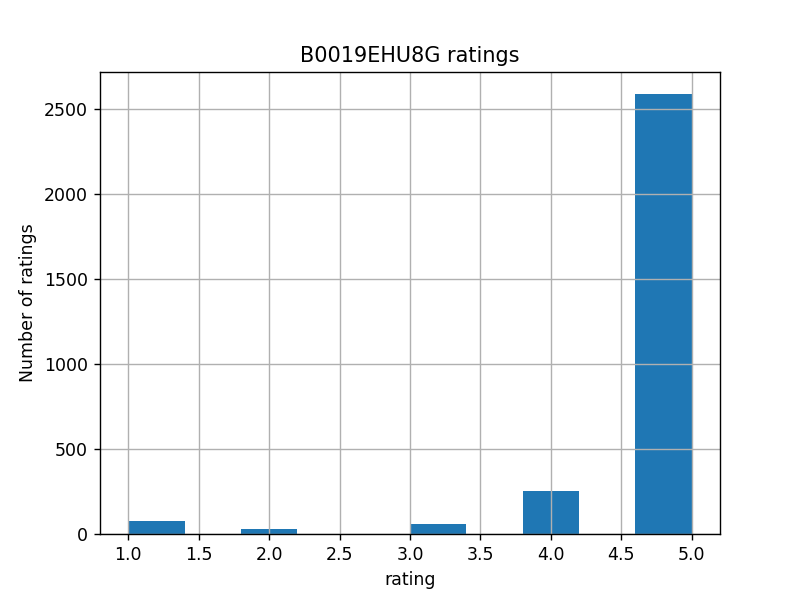

In [57]:
import matplotlib.pyplot as plt
df.loc[df['productId'] == 'B0019EHU8G']['ratings'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('B0019EHU8G ratings')
plt.show();

As it is confirmd from the plot most of the reviewers rated this product 5, so the prediction is correct.

The author of Surprise has written a function we can use to get the top-N recommendations for each user in our dataset. 
I'll be using <a href = https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user>same function.</a>

In [42]:
from collections import defaultdict

"""Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
"""

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, round(est,2)))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


top_n = get_top_n(predictions, n=10)

In [44]:
Recom = {}
for i in range(10):
    Recom[dfr.reviewerId[i]] = top_n[dfr.reviewerId[i]]

In [45]:
for i in Recom :
    print(i, Recom[i])

A2B4F6LP0ZLI8E [('0594296420', 4.3)]
A1RKH6803HVOQL [('0594296420', 4.3)]
A3ZNVCQCG57AY [('B000YK0MUO', 4.27)]
A1HM74IXWXQ5D8 []
A2DUI0YVE1DZ48 []
AH3LYMIBZ6DKF []
A3AW83CCH2SYAG []
A3IL8P9RPBUW2X []
AOZZ0CTG5RMW1 [('0972683275', 4.44)]
A2IDCSC6NVONIZ [('B00005V51P', 4.55)]


This function doesn't always recommend ten items. May be because the data is very sparse, and there is a high number of customers who have only rated one product, as well as many products that have only one rating. 

A simple yet effective way to generate recommendations is to recommend the most popular products.

First, I need to build a dataset of popular products. Each person could define popular in a different way, but in this scenario I'm only going to consider products that have received at least 100 reviews. Then, I'll find the average rating for each product and sort them in descending order.

In [46]:
review_count = dfr['productId'].value_counts()
review_count_ten = review_count[review_count >= 100]
hundred_reviews = dfr[dfr['productId'].isin(review_count_ten.index)]
items = (hundred_reviews[['productId', 'ratings'
                          ]].groupby('productId').agg('mean').sort_values(
                              'ratings', ascending=False).index)

Go over each user's recommendations and add the most popular products that aren't already recommended.

In [47]:
def recommendation_list(user_list, user_predictions, item_list):
    recommendations = {}
    for i in range(100):
        user = user_list[i]
        if user in user_predictions:
            user_recs = [
                user_predictions[user][i][0]
                for i in range(len(user_predictions[user]))
            ]
            if user_recs:
                num_items = len(user_recs)
            else:
                num_items = 0

            idx = 0
            while num_items < 10:
                product = item_list[idx]
                if product not in user_recs:
                    user_recs.append(product)
                    num_items = len(user_recs)
                idx += 1
            recommendations.update({user: user_recs})
    return recommendations


recs = recommendation_list(dfr['reviewerId'].unique().tolist(), top_n, items)

In [48]:
example_user = dfr['reviewerId'].unique().tolist()[1]
recs[example_user]

['0594296420',
 'B007SZ0E1K',
 'B007SZ0EHE',
 'B0055N2L22',
 'B005LJQPE0',
 'B00009R96C',
 'B0079MX4Q4',
 'B005KWHJES',
 'B007JY58FM',
 'B004FA8NOQ']

### Conclusion

There are a many ways to build and improve this recommender system.
I couldn't use k-NN algorithms from the Surprise package, as it needs more memory, neither I could complete it on google colab.
Use more tuned parameters
I did some basic cross validation to select the best parameters. To improve the recommendations, tune these parameters and make sure that the algorithm is serving the best recommendations possible with the data available.